In [1]:
import ipsuite as ips

2023-05-10 12:48:21,270 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [2]:
mapping = ips.geometry.BarycenterMapping(data=None)
thermostat = ips.calculators.LangevinThermostat(
    temperature=300, friction=0.01, time_step=0.5
)

with ips.Project(automatic_node_names=True) as project:
    mol = ips.configuration_generation.SmilesToAtoms(smiles="O")

    packmol = ips.configuration_generation.Packmol(
        data=[mol.atoms], count=[10], density=997
    )

    cp2k = ips.calculators.CP2KSinglePoint(
        data=packmol,
        cp2k_files=["GTH_BASIS_SETS", "GTH_POTENTIALS", "dftd3.dat"],
        cp2k_shell="cp2k_shell.psmp",
    )

    geopt = ips.calculators.ASEGeoOpt(
        model=cp2k,
        data=packmol.atoms,
        optimizer="BFGS",
        run_kwargs={"fmax": 0.1},
    )

    md = ips.calculators.ASEMD(
        model=cp2k,
        thermostat=thermostat,
        data=geopt.atoms,
        data_id=-1,
        sampling_rate=1,
        dump_rate=1,
        steps=5000,
    )

    test_data = ips.configuration_selection.RandomSelection(
        data=md, n_configurations=250
    )
    val_data = ips.configuration_selection.RandomSelection(
        data=md,
        n_configurations=50,
        exclude_configurations=test_data.selected_configurations,
    )
    train_data = ips.configuration_selection.RandomSelection(
        data=md,
        n_configurations=250,
        exclude_configurations=[
            test_data.selected_configurations,
            val_data.selected_configurations,
        ],
    )

    model = ips.models.MACE(data=train_data, test_data=val_data)

    predictions = ips.analysis.Prediction(data=val_data, model=model)
    analysis = ips.analysis.PredictionMetrics(data=predictions)

    ml_md = ips.calculators.ASEMD(
        model=model,
        thermostat=thermostat,
        data=geopt.atoms,
        data_id=-1,
        sampling_rate=1,
        dump_rate=1,
        steps=5000,
    )

project.run(repro=False)

Running DVC command: 'stage add --name SmilesToAtoms --force ...'
Running DVC command: 'stage add --name Packmol --force ...'
Running DVC command: 'stage add --name CP2KSinglePoint --force ...'
Running DVC command: 'stage add --name ASEGeoOpt --force ...'
Running DVC command: 'stage add --name ASEMD --force ...'
Running DVC command: 'stage add --name ASEMD_thermostat --force ...'
Running DVC command: 'stage add --name ConfigurationSelection --force ...'
Running DVC command: 'stage add --name ConfigurationSelection_1 --force ...'
Running DVC command: 'stage add --name ConfigurationSelection_2 --force ...'
Running DVC command: 'stage add --name MLModel --force ...'
Running DVC command: 'stage add --name Prediction --force ...'
Running DVC command: 'stage add --name PredictionMetrics --force ...'
Running DVC command: 'stage add --name ASEMD_1 --force ...'
Running DVC command: 'stage add --name ASEMD_1_thermostat --force ...'


# Analyse the results

In [3]:
analysis.load()

In [10]:
analysis.energy_df.iloc[:5]

,Unnamed: 0,true,prediction
0,0,-4488.799096,-4488.786458
1,1,-4488.619281,-4488.604806
2,2,-4488.932046,-4488.926759
3,3,-4489.150568,-4489.148408
4,4,-4488.972237,-4488.960681


### DFT DATA

In [13]:
md.load()
md.atoms[:5]

[Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...))]

## Simulation Data

In [14]:
ml_md.load()
ml_md.atoms[:5]

[Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2', pbc=True, cell=[6.6946734740471925, 6.6946734740471925, 6.6946734740471925], momenta=..., calculator=SinglePointCalculator(...))]

## Compute RDF

In [24]:
import ase
import ase.geometry.analysis
import matplotlib.pyplot as plt
import numpy as np

In [19]:
analysis = ase.geometry.analysis.Analysis(ml_md.atoms)
data = analysis.get_rdf(rmax=3.0, nbins=100, elements=["H", "O"])

In [27]:
analysis = ase.geometry.analysis.Analysis(md.atoms)
dft_data = analysis.get_rdf(rmax=3.0, nbins=100, elements=["H", "O"])

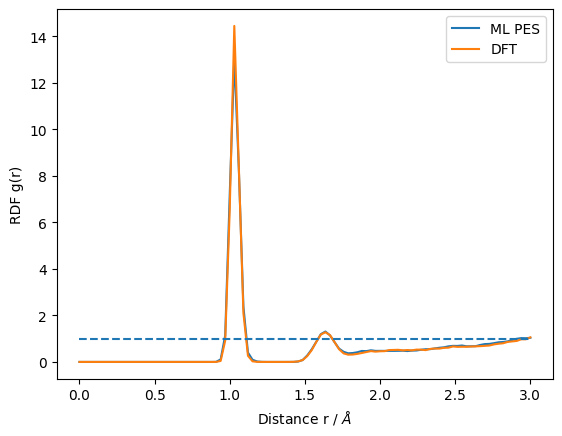

In [35]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, 3.0, 100), np.mean(data, axis=0), label="ML PES")
ax.plot(np.linspace(0, 3.0, 100), np.mean(dft_data, axis=0), label="DFT")
ax.hlines(xmin=0, xmax=3, y=1, ls="--")
ax.set_xlabel(r"Distance r / $\AA$")
ax.set_ylabel("RDF g(r)")
ax.legend()